In [ ]:
import ignite
from ignite.engine import Engine , Events
from ignite.metrics import RunningAverage


In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np



In [3]:
import gymnasium as gym
from types import SimpleNamespace
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
try:
    import ptan
except ImportError:
    !pip install ptan
    import ptan

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.6 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [5]:
HYPER_PARAMETERS = {
                        'CartPole_dqn':SimpleNamespace(**{
                                                        'env_name': "CartPole-v1",
                                                        'stop_reward': 25.0,
                                                        'run_name': 'CartPole',
                                                        'replay_size': 10000,
                                                        'replay_initial': 5000,
                                                        'target_net_sync': 10,
                                                        'epsilon_frames': 10 ** 2,
                                                        'initial_epsilon': 1.0,
                                                        'final_epsilon': 0.1,
                                                        'learning_rate': 0.001,
                                                        'gamma': 0.9,
                                                        'batch_size': 256,
                                                        'SEED':123
                                                        })
                    }

HYPER_PARAMETERS=HYPER_PARAMETERS['CartPole_dqn']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
env=gym.make(HYPER_PARAMETERS.env_name)

In [7]:
class DQNGridEnv(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(DQNGridEnv, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x.float())




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Q_net = DQNGridEnv(env.observation_space.shape[0],128,env.action_space.n).to(device)
tgt_net=ptan.agent.TargetNet(Q_net)


In [8]:
class EpsilonDecay:
    
    def __init__(self, initial_epsilon, final_epsilon , epsilon_frame=10**5):
        
        self.initial_epsilon=initial_epsilon
        self.final_epsilon=final_epsilon
        self.epsilon_frame=epsilon_frame
        self.updated_epsilon=initial_epsilon

    def update_epsilon(self, frame_idx):
        eps = self.initial_epsilon - (frame_idx / self.epsilon_frame)
        self.updated_epsilon = max(self.final_epsilon, eps)


initial_epsilon = HYPER_PARAMETERS.initial_epsilon
final_epsilon=HYPER_PARAMETERS.final_epsilon
epsilon_frame=HYPER_PARAMETERS.epsilon_frames

epsilon_tracker=EpsilonDecay(initial_epsilon, final_epsilon , epsilon_frame)

action_selector=ptan.actions.EpsilonGreedyActionSelector(epsilon=epsilon_tracker.updated_epsilon)
dqn_agent=ptan.agent.DQNAgent(Q_net,action_selector,device=device)


In [9]:
gamma=HYPER_PARAMETERS.gamma
replay_buffer_size=HYPER_PARAMETERS.replay_size
initial_size_replay_buffer=HYPER_PARAMETERS.replay_initial
batch_size=HYPER_PARAMETERS.batch_size

exp_source=ptan.experience.ExperienceSourceFirstLast(env,dqn_agent,gamma=gamma)
replay_buffer=ptan.experience.ExperienceReplayBuffer(exp_source,replay_buffer_size)



In [10]:
optimizer = optim.Adam(Q_net.parameters(),lr=HYPER_PARAMETERS.learning_rate)



In [11]:
import ptan.ignite as ptan_ignite

In [12]:
def attach_end_of_episode_handlers(engine, exp_source,bound_reward=None):
    handler = ptan_ignite.EndOfEpisodeHandler(exp_source,bound_avg_reward=bound_reward)
    handler.attach(engine)

def ignite_running_average_handlers(engine,metricts):
    for metric in metricts: 
        run_avg = RunningAverage(output_transform=lambda v: v[metric])              
        run_avg.attach(engine, 'running_avg_'+ metric)                

In [13]:
def metrics_tracker(engine):

    
    @engine.on(Events.ITERATION_COMPLETED)
    def iteration_level_metric_tracker(engine):
        engine.state.output_metrics['loss'].append(engine.state.output['loss'])
        engine.state.output_metrics['epsilon'].append(engine.state.output['epsilon'])

    @engine.on(ptan_ignite.EpisodeEvents.EPISODE_COMPLETED)
    def episode_completed(engine):
        print("Episode %d: reward=%.0f, steps=%s, "
              "speed=%.1f f/s, " % (
            engine.state.episode, engine.state.episode_reward,
            engine.state.episode_steps,
            engine.state.metrics.get('avg_fps', 0)))
        
        engine.state.output_metrics['episode_reward'].append(engine.state.episode_reward)
        engine.state.output_metrics['episode_steps'].append(engine.state.episode_steps)
        engine.state.output_metrics['running_average_episode_reward'].append(engine.state.metrics['avg_reward'])
        engine.state.output_metrics['running_average_episode_steps'].append(engine.state.metrics['avg_steps'])
        

    @engine.on(ptan_ignite.EpisodeEvents.BOUND_REWARD_REACHED)
    def game_solved(engine):
        print("Game solved after %d episodes "
              "and %d iterations!" % (

            engine.state.episode, engine.state.iteration))
        
        engine.should_terminate = True
        torch.save(engine.state.output['Q_net_state_dict'],'/kaggle/working/last_q_net.pth')

    @engine.on(ptan_ignite.EpisodeEvents.EPISODE_COMPLETED)
    def best_reward_reached(engine):
        
        if not hasattr(engine.state, 'best_reward'):
            engine.state.best_reward = -float('inf')

        episode_reward = engine.state.episode_reward

        if episode_reward > engine.state.best_reward:
            engine.state.best_reward = episode_reward
            print(f"New best reward: {engine.state.best_reward}! Saving the model.")
            torch.save(engine.state.output['Q_net_state_dict'],'/kaggle/working/best_q_net.pth')



    

In [14]:
def calc_loss_dqn(batch, net, tgt_net, gamma, device="cpu"):

    # this is a function to calculate loss for DQN 

    states, actions, rewards, dones, next_states = unpack_function_expsourcefirstlast_to_nparray(batch) #a batch of ExperienceSourceFirstLast is unpacked and appended to np.arrays


    # inputs are np.array and change to tensor
    states_tensor = torch.tensor(states).to(device)
    next_states_tensor = torch.tensor(next_states).to(device)
    actions_tensor = torch.tensor(actions).to(device)
    rewards_tensor = torch.tensor(rewards).to(device)
    done_mask_tensor = torch.BoolTensor(dones).to(device)


    actions_tensor = actions_tensor.unsqueeze(-1)
    predicted_q_s_a = net(states_tensor).gather(1, actions_tensor)
    predicted_q_s_a = predicted_q_s_a.squeeze(-1)
    with torch.no_grad():
        q_s_prime_a_prime = tgt_net(next_states_tensor).max(1)[0]
        q_s_prime_a_prime[done_mask_tensor] = 0.0                     

    Expected_q_s_a = q_s_prime_a_prime.detach() * gamma + rewards_tensor
    return nn.MSELoss()(predicted_q_s_a, Expected_q_s_a)


In [15]:
def batch_generator_from_replaybuffer(buffer ,initial_buffer_size , batch_size):

    # buffer is a replay buffer object
    # there is no output if number of entries in buffer is less than initial_buffer_size
    # after that it will return a batch of size batch_size

    buffer.populate(initial_buffer_size)
    while True:
        buffer.populate(1)
        yield buffer.sample(batch_size)


In [16]:
def unpack_function_expsourcefirstlast_to_nparray(batch): 

    states, actions, rewards, dones, last_states = [],[],[],[],[]
    for exp in batch:
        state = np.array(exp.state)
        states.append(state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            lstate = state  # the result will be masked anyway
        else:
            lstate = np.array(exp.last_state)
        last_states.append(lstate)
    return np.array(states, copy=False), np.array(actions), \
           np.array(rewards, dtype=np.float32), \
           np.array(dones, dtype=np.uint8), \
           np.array(last_states, copy=False)


In [17]:
def process_function(engine , batch):
    optimizer.zero_grad()
    MSE_Loss_Q_values= calc_loss_dqn(batch, Q_net, tgt_net.target_model, gamma, device=device)
    MSE_Loss_Q_values.backward()
    optimizer.step()
    epsilon=epsilon_tracker.updated_epsilon
    epsilon_tracker.update_epsilon(engine.state.iteration)
    if engine.state.iteration % HYPER_PARAMETERS.target_net_sync == 0:
        tgt_net.sync()

    return {
            "loss": MSE_Loss_Q_values.item(),
            "epsilon": epsilon,
            "Q_net_state_dict":Q_net.state_dict()
        }

In [18]:

engine_obj = Engine(process_function)
attach_end_of_episode_handlers(engine_obj, exp_source,bound_reward=HYPER_PARAMETERS.stop_reward)
ignite_running_average_handlers(engine_obj,['loss'])

engine_obj.state.output_metrics=defaultdict(list)
metrics_tracker(engine_obj)

batch=batch_generator_from_replaybuffer(replay_buffer ,initial_size_replay_buffer , batch_size)
state=engine_obj.run(batch)

output_metrics=state.output_metrics

Episode 1: reward=12, steps=12, speed=0.0 f/s, 
New best reward: 12.0! Saving the model.
Episode 2: reward=33, steps=33, speed=0.0 f/s, 
New best reward: 33.0! Saving the model.
Episode 3: reward=13, steps=13, speed=0.0 f/s, 
Episode 4: reward=21, steps=21, speed=0.0 f/s, 
Episode 5: reward=12, steps=12, speed=0.0 f/s, 
Episode 6: reward=20, steps=20, speed=0.0 f/s, 
Episode 7: reward=34, steps=34, speed=0.0 f/s, 
New best reward: 34.0! Saving the model.
Episode 8: reward=13, steps=13, speed=0.0 f/s, 
Episode 9: reward=47, steps=47, speed=0.0 f/s, 
New best reward: 47.0! Saving the model.
Episode 10: reward=30, steps=30, speed=0.0 f/s, 
Episode 11: reward=23, steps=23, speed=0.0 f/s, 
Episode 12: reward=47, steps=47, speed=0.0 f/s, 
Episode 13: reward=16, steps=16, speed=0.0 f/s, 
Episode 14: reward=26, steps=26, speed=0.0 f/s, 
Episode 15: reward=52, steps=52, speed=0.0 f/s, 
New best reward: 52.0! Saving the model.
Episode 16: reward=45, steps=45, speed=0.0 f/s, 
Episode 17: reward=1

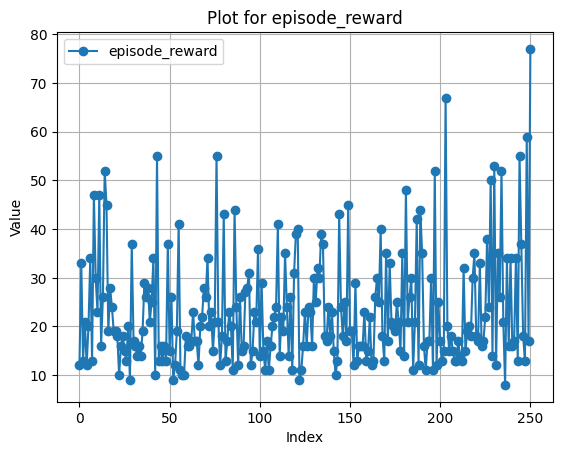

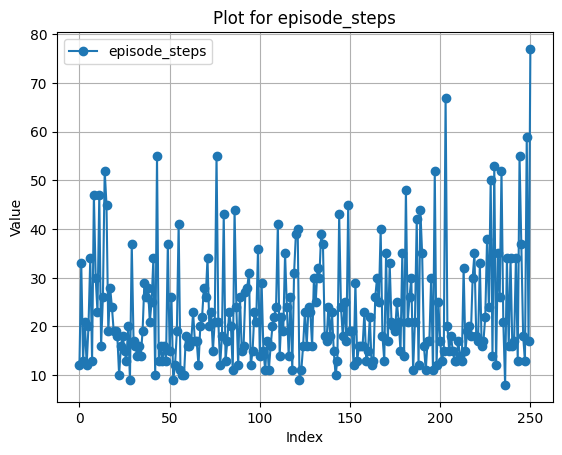

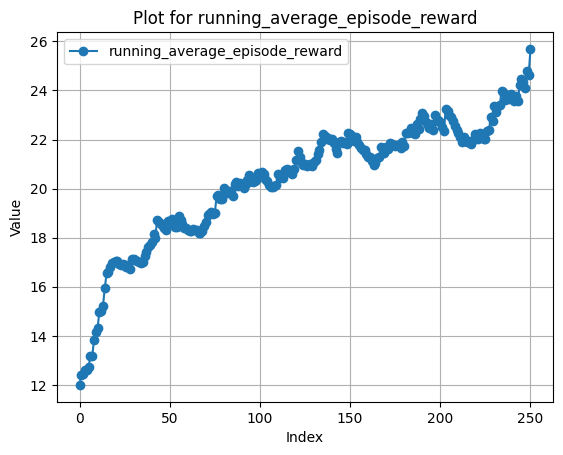

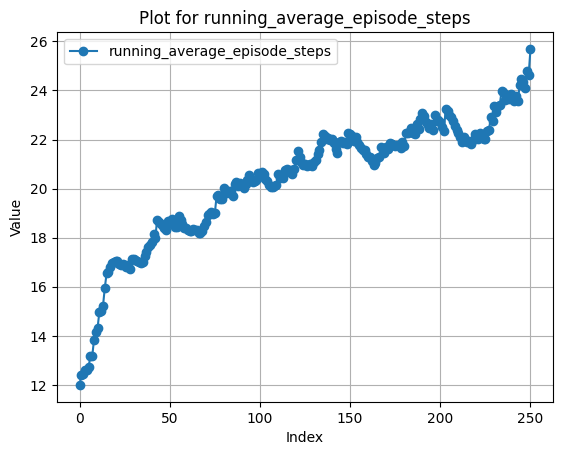

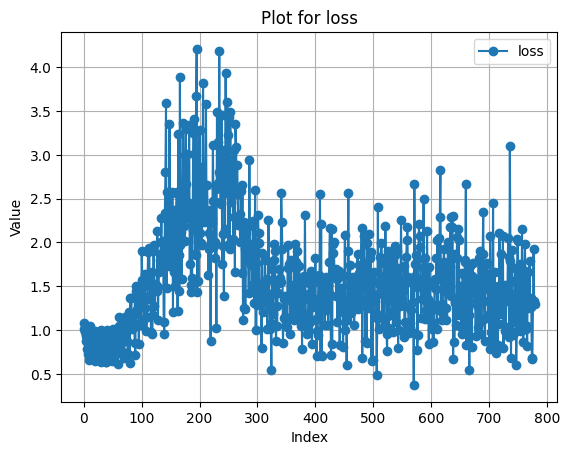

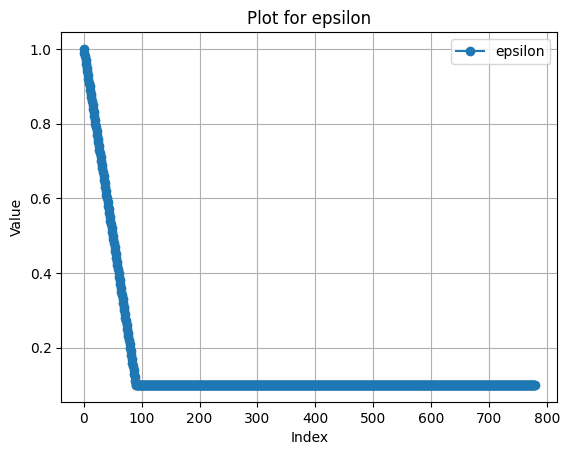

In [19]:
for key, values in output_metrics.items():
    plt.figure()  # Create a new figure for each plot
    plt.plot(values, marker='o', label=key)  # Plot the values
    plt.title(f"Plot for {key}")  # Set the title
    plt.xlabel("Index")  # X-axis label
    plt.ylabel("Value")  # Y-axis label
    plt.legend()  # Add a legend
    plt.grid(True)  # Add a grid for better visualization
    plt.show()  # Display the plot